# Clustering Notebook
Christopher Marais

gmarais@ufl.edu

2023/12/14

<br>

The Aim of this notebook is to take in the DTW distance matrix and perfrom hierarchical clustering. The clustering is done with a distance parameter that acts as a threshold to decide when two data points are within the same cluster or not. The threshold is chosen based on the distribution of all the distances and is selected as the point at which the distribution starts to plateau. 

Runtime for this notebook is between 1-2 hours.

<br>

Input: `/02_Clean_data/01_dtw_distance_matrix.npy`, `/02_Clean_data/01_recording_event_times_labels_binary.csv`

↓

Process: `</03_Scripts/02_Clustering.ipynb>`

↓

Output: `/02_Clean_data/02_recording_event_times_labels_binary_clustered.csv`, `/04_Visualizations/00_dtw_distance_count_distribution.png`

<br>

-----------

### Import Packages

In [1]:
import os
import numpy as np
# import pandas as pd # use pandas for more functionality
import modin.pandas as pd # use modin for speed
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import seaborn as sns

### Define Working Directory

In [2]:
# get working directory as paerent directory of current directory
cwd = os.getcwd()
pwd = os.path.dirname(cwd)

### Import Data

In [3]:
# Load the distance matrix data
dtw_distance_matrix = np.load(pwd + "/02_Clean_data/01_dtw_distance_matrix.npy")

# import labels data
columns_to_import = ['order','start_time','end_time','collection_key','subject','behavior_label','units','event_timestamps']
data_df = pd.read_csv(pwd + "/02_Clean_data/01_recording_event_times_labels_binary.csv", usecols=columns_to_import)

### Estimate Plateau Point
Find the point at which the distance distribution plateaus.

Plateau starts at: 3.6358715585454964


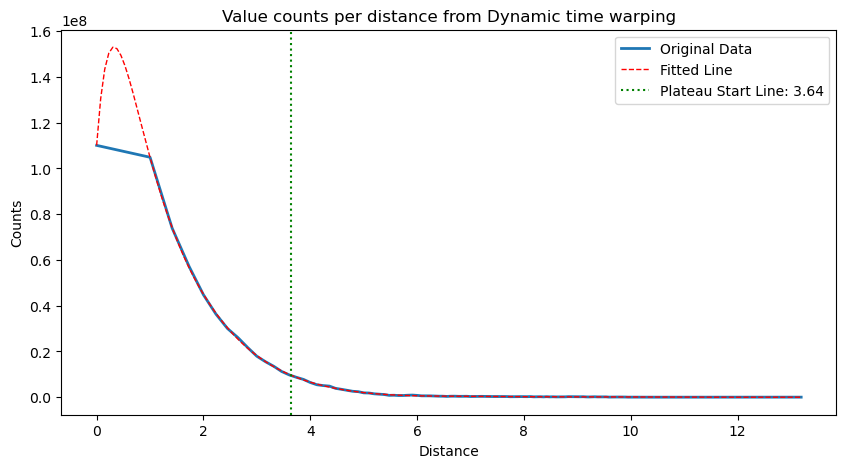

In [5]:
# flatten the matrix into a single array
dtw_arr = dtw_distance_matrix.flatten()
unique_elements, counts = np.unique(dtw_arr, return_counts=True)

# put value ounts in a dataframe
dist_counts_df = pd.DataFrame()
dist_counts_df['distance'] = unique_elements
dist_counts_df['counts'] = counts

# Function to find the extremum of the second derivative
def extremum_of_second_derivative(x):
    return -abs(second_derivative(x))  # Negative because we want to maximize the absolute value

# fit a line to the data points
# Fit a polynomial curve
degree = 20  # Adjust based on your data
coefficients = np.polyfit(
    dist_counts_df['distance'], 
    dist_counts_df['counts'], 
    degree)
polynomial = np.poly1d(coefficients)

# find the extremum of the polynomial
# First derivative (slope)
first_derivative = np.poly1d(np.polyder(polynomial, 1))
# Define a threshold for what you consider 'close to zero'
slope_threshold = 1e7  # Adjust this value based on your data

# Evaluate the slope across the range of x values
# we select 1 as the min vlaue to avoid the first derivative being zero at the start
x_vals = np.linspace(1, dist_counts_df['distance'].max(), 1000)  # More points for a finer analysis
slopes = first_derivative(x_vals)

# Find where the slope is consistently near zero
plateau_points = x_vals[np.abs(slopes) < slope_threshold]

# Assuming the first point of this condition is where it starts to plateau
if len(plateau_points) > 0:
    plateau_start = plateau_points[0]
    print(f"Plateau starts at: {plateau_start}")
else:
    print("No plateau found based on the given threshold.")

# Generate some x values for plotting the fit
dist_counts_df['fitted_distance'] = np.linspace(dist_counts_df['distance'].min(), dist_counts_df['distance'].max(), 175)
dist_counts_df['fitted_counts'] = polynomial(dist_counts_df['fitted_distance'])

# Create a figure with a wider aspect ratio
plt.figure(figsize=(10, 5))

# Creating the line plot
sns.lineplot(
    data=dist_counts_df, 
    x='distance', 
    y='counts', 
    label='Original Data',
    linewidth = 2)

# Add the fitted line
sns.lineplot(
    data=dist_counts_df, 
    x='fitted_distance',
     y='fitted_counts',
    color='red', 
    label='Fitted Line', 
    linestyle='--',
    linewidth = 1)

# Add vertical line at the extremum point
plt.axvline(
    x=plateau_start, 
    color='green', 
    linestyle=':',
    label=f"Plateau Start Line: {round(plateau_start,2)}")  # Add a vertical line

# Adding labels, title, and legend
plt.xlabel('Distance')
plt.ylabel('Counts')
plt.title('Value counts per distance from Dynamic time warping')
plt.legend()

# Save the plot
plt.savefig(pwd + "/04_Visualizations/00_dtw_distance_count_distribution.png")

# Display the plot
plt.show()

### Clustering

In [6]:
# Perform hierarchical clustering using the distance matrix
linkage_matrix = sch.linkage(dtw_distance_matrix, method='weighted') # having weighted linkages helps with clusters of different sizes and shapes which we expect to see.

# Form flat clusters from the hierarchical clustering defined by the given linkage matrix
# We use the plateau start to define the distance between what is inside or outside a cluster
clusters = fcluster(linkage_matrix, t=plateau_start, criterion='distance') # find a distance to separate clusters by

### Save Output Data

In [7]:
# add cluster data to labels data
data_df['cluster'] = clusters 

# drop the event timestamps column
data_df = data_df.drop(columns=['event_timestamps'])

# save data to csv again
data_df.to_csv(pwd + "/02_Clean_data/02_recording_event_times_labels_binary_clustered.csv", index=False)

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.
